In [1]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import json
import anndata as ad

import re

from matplotlib import ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import mpl_fontkit as fk
fk.install("Lato")
fk.set_font("Lato")

Font name: `Lato`


In [4]:
sc.settings.figdir = './Endometriosis-Figures/'

In [5]:
results_dir = './MT-2025-02-18/'

## Load data

In [6]:
adata = sc.read_h5ad('/nfs/team292/eg22/Datasets/Endometrium/endometriumAtlasV2_cells_with_counts.h5ad', backed='r')

In [7]:
selected_cells = [
'1 | SOX9 basalis',
'2 | SOX9 functionalis I',
'3 | SOX9 functionalis II',
'4 | SOX9 luminal',
'6 | preGlandular',
'7 | Glandular',
'8 | Glandular secretory',
'10 | preLuminal',
'11 | Luminal',
'12 | preCiliated',
'13 | Ciliated',
'17 | uSMCs',
'22 | eStromal MMPs',
'23 | eStromal',
'25 | dStromal early',
'26 | dStromal mid',
'27 | dStromal late',
'28 | Fibroblast basalis',
]

cells_to_load = adata.obs[adata.obs['label_long'].isin(selected_cells)].celltype.unique().tolist()

In [8]:
cells_to_load

['eStromal',
 'uSMCs',
 'preGlandular',
 'Fibroblast_basalis',
 'Ciliated',
 'SOX9_functionalis_II',
 'dStromal_mid',
 'eStromal_MMPs',
 'dStromal_early',
 'preLuminal',
 'SOX9_basalis',
 'SOX9_luminal',
 'Glandular',
 'dStromal_late',
 'preCiliated',
 'Luminal',
 'SOX9_functionalis_I',
 'Glandular_secretory']

In [9]:
cells_to_exclude = ['i18 | Red blood cell', '9 | Glandular secretory FGF7', 'i4c | T cell cycling', 'i6c | uNK1 cycling']

In [10]:
with open(f'{results_dir}/cell_type_mapping.json', mode='r') as fp:
    cell_dict = json.load(fp)

In [11]:
for i, ct in enumerate(cells_to_load):
    mt_df = pd.read_csv('{}/MT_dataframe_{}.csv'.format(results_dir, cell_dict[ct]), index_col=0)
    if i == 0:
        mt_adata = sc.AnnData(X=mt_df, obs=adata[mt_df.index].obs)
    else:
        mt_adata = ad.concat([mt_adata, sc.AnnData(X=mt_df, obs=adata[mt_df.index].obs)], join='outer')

In [12]:
mt_imm = sc.read_h5ad('/nfs/team292/eg22/Metabolic-Tasks/Endometrium/HECA/Imm-MT-2025-02-18/Immune-HECA_metabolic_tasks.h5ad')

In [13]:
mt_total = ad.concat([mt_adata, mt_imm], join='inner')

In [14]:
mt_total.obs['Endometrial_pathology'].unique()

['C', 'E', 'E + F', 'E + A', 'E + A + F']
Categories (5, object): ['C', 'E', 'E + A', 'E + A + F', 'E + F']

In [15]:
mt_total = mt_total[~mt_total.obs['label_long'].isin(cells_to_exclude)]

In [16]:
mt_total.obs['Endometriosis'] = mt_total.obs['Endometrial_pathology'].apply(lambda x: 'Endometriosis' if x != 'C' else 'Control')
mt_total.obs['E_celltype'] = mt_total.obs['Endometriosis'].astype(str) + ' - ' + mt_total.obs['label_long'].astype(str)

In [17]:
# Remove cells with low sample size
control_cells = mt_total.obs.groupby(['Endometriosis', 'label_long'])['E_celltype'].count().loc['Control']
endo_cells = mt_total.obs.groupby(['Endometriosis', 'label_long'])['E_celltype'].count().loc['Endometriosis']

## Differential Analysis

In [37]:
# Filters
min_n = 170
max_log2ratio = 6#3

testable_cells = control_cells.index[(control_cells >= min_n) & (endo_cells >= min_n) & (np.log2(control_cells / endo_cells).abs() <= max_log2ratio)].tolist()

In [38]:
testable_cells

['3 | SOX9 functionalis II',
 '4 | SOX9 luminal',
 '6 | preGlandular',
 '7 | Glandular',
 '8 | Glandular secretory',
 '10 | preLuminal',
 '11 | Luminal',
 '12 | preCiliated',
 '13 | Ciliated',
 '22 | eStromal MMPs',
 '23 | eStromal',
 '25 | dStromal early',
 '26 | dStromal mid',
 '27 | dStromal late',
 'i1 | B cell',
 'i3 | T cell CD4',
 'i4 | T cell CD8',
 'i5 | T Reg',
 'i6 | uNK1',
 'i7 | uNK2',
 'i8 | uNK3',
 'i9 | ILC3',
 'i10 | Peripheral lymphocyte',
 'i12 | cDC2',
 'i13 | eM1',
 'i14 | eM2']

In [39]:
de_results = sccellfie.stats.scanpy_differential_analysis(mt_total[mt_total.obs['label_long'].isin(testable_cells)],
                                                          cell_type=None,
                                                          cell_type_key='label_long',
                                                          condition_key='Endometriosis',
                                                          min_cells=0, # Filter already applied in testable_cells
                                                          )

Processing DE analysis: 100%|██████████| 26/26 [02:07<00:00,  4.89s/it]


In [40]:
de_results.head()

,cell_type,feature,group1,group2,log2FC,test_statistic,p_value,cohens_d,n_group1,n_group2,median_group1,median_group2,median_diff,adj_p_value
0,23 | eStromal,Mevalonate synthesis,Control,Endometriosis,0.402569,37.829868,0.000000e+00,0.185087,32446,23166,0.1152074950255597,0.17064947985405676,0.055442,0.000000e+00
1,23 | eStromal,Degradation of uracil,Control,Endometriosis,0.300666,36.494434,1.358830e-291,0.246746,32446,23166,0.1693266799196705,0.25957265681873276,0.090246,5.478645e-290
2,23 | eStromal,Degradation of cytosine,Control,Endometriosis,0.300666,36.494434,1.358830e-291,0.246746,32446,23166,0.1693266799196705,0.25957265681873276,0.090246,5.478645e-290
3,23 | eStromal,Conversion of glutamate to glutamine,Control,Endometriosis,0.339872,34.953400,1.149692e-267,0.265364,32446,23166,0.40606590146321825,0.7323877578739179,0.326322,4.127024e-266
4,23 | eStromal,Post translational translocation,Control,Endometriosis,0.150839,32.975052,1.850977e-238,0.295020,32446,23166,0.5498094988566284,0.6103785938402497,0.060569,5.478105e-237


In [41]:
de_results.reset_index().to_csv(f'{sc.settings.figdir}/DE-Endometriosis2.csv')

## Visualizations

### Significant tasks

In [42]:
# This function is used to keep endometrial cells first, using their cluster number at the beginning,
# Then immune cells come, sorting them by the number after the 'i'
sort_lambda = lambda x: pd.Series([int(re.findall("\d+", s.split(' | ')[0])[0]) if 'i' not in s.split(' | ')[0] else int(re.findall("\d+", s.split(' | ')[0])[0])+1000 for s in x])

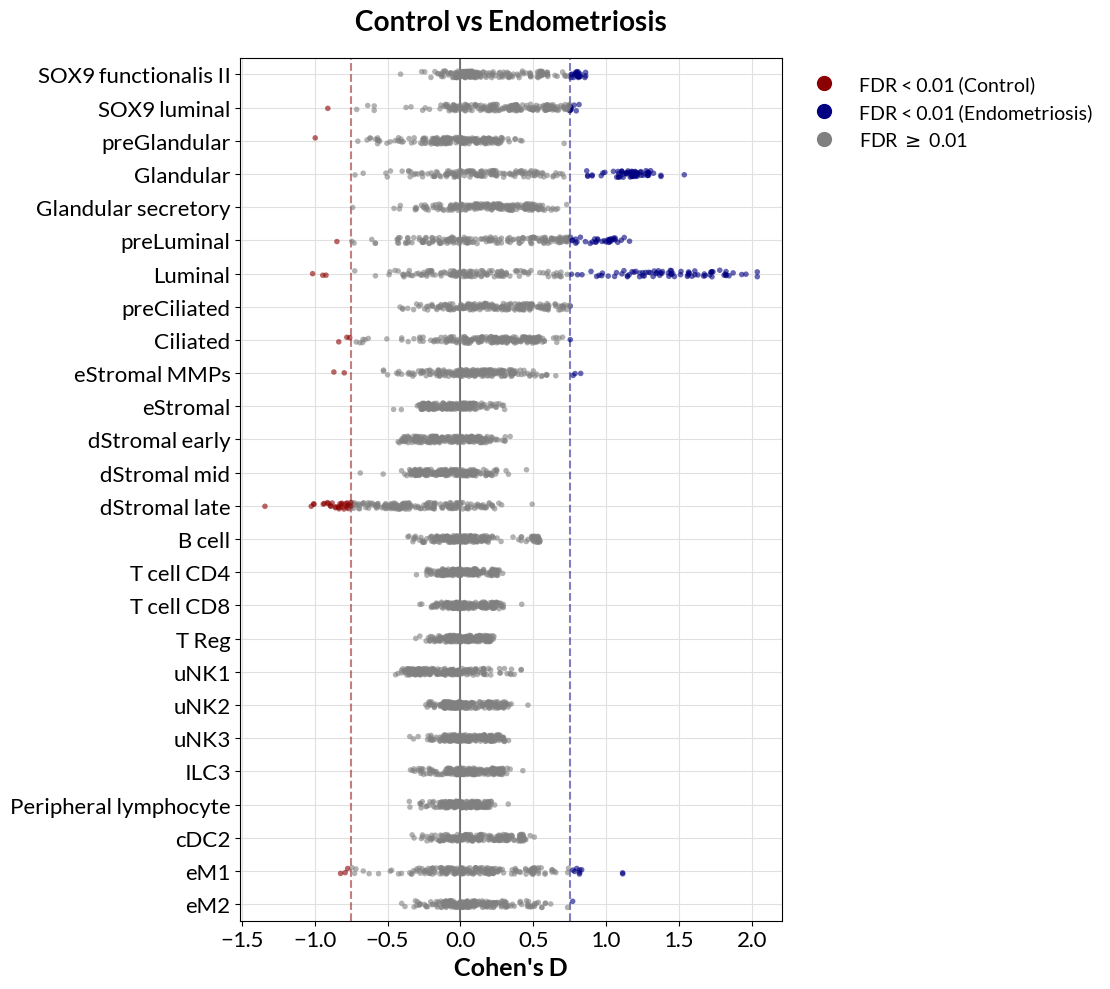

In [43]:
cohen_threshold = 0.75
pval_threshold = 0.01
logfc_threshold = np.log2(1.1)

fig, ax, sig = sccellfie.plotting.create_beeswarm_plot(de_results,
                                                       x='cohens_d', 
                                                       cohen_threshold=cohen_threshold, 
                                                       pval_threshold=pval_threshold,
                                                       logfc_threshold=logfc_threshold,
                                                       show_n_significant=False,
                                                       strip_jitter=True,
                                                       sort_lambda=sort_lambda,
                                                       lgd_bbox_to_anchor=(1.01, 1),
                                                       ticks_fontsize=16,
                                                       labels_fontsize=18,
                                                       figsize=(12, 10), )

# Remove cluster number
ylabels = ax.get_yticklabels()
ax.set_yticklabels([t.get_text().split(' | ')[1] for t in ylabels])
ax.set_ylabel('')


plt.savefig(f'{sc.settings.figdir}/Endometriosis-DE.pdf', dpi=300, bbox_inches='tight')

In [44]:
sig_tasks = sig.reset_index().feature.unique().tolist()

agg = sccellfie.expression.aggregation.agg_expression_cells(mt_total, 
                                                            groupby='E_celltype', 
                                                            gene_symbols=sig_tasks, 
                                                            agg_func='trimean')

In [45]:
filtered_sig_tasks = agg.columns.tolist() # agg.columns.tolist() #agg.loc[:, (agg > 1.).any(axis=0)].columns.tolist()

### Visualize DB properties of significant tasks

In [46]:
sccellfie_db = sccellfie.datasets.load_sccellfie_database(organism='human')

In [47]:
def plot_single(condition, ax, pathway, sig_data):
    pathway_counts = {'System': pd.DataFrame(), 'Subsystem': pd.DataFrame()}

    for c, df in sig_data.reset_index().groupby('cell_type'):
        for k, v in pathway_counts.items():
            df2 = df.set_index('feature').join(sccellfie_db['task_info'].set_index('Task'), how='inner')
            df2 = df2.loc[df2.log2FC > 0] if condition == 'up' else df2.loc[df2.log2FC < 0]
            df2 = df2.value_counts(k).to_frame().reset_index()
            df2['cell_type'] = c
            df2 = df2[['cell_type', k, 'count']]
            df2[k] = df2[k].apply(lambda x: x.upper())
            pathway_counts[k] = pd.concat([pathway_counts[k], df2])

    df = pathway_counts[pathway].sort_values('count')
    totals = df.groupby('cell_type')['count'].sum()

    df_normalized = df.copy()
    df_normalized['fraction'] = df.groupby('cell_type')['count'].transform(lambda x: x / x.sum())
    pivoted_data = df_normalized.pivot(index='cell_type', columns=pathway, values='fraction')
    pivoted_data = pivoted_data.sort_index(key=sort_lambda).fillna(0.)

    n_systems = len(pivoted_data.columns)
    colors = glasbey.extend_palette('Set2', palette_size=max([n_systems, 10]))

    pivoted_data.plot(kind='barh', stacked=True, ax=ax, color=colors, legend=False)
    ax.set_xlim((0, 1))
    ax.invert_yaxis()

    ylabels = ax.get_yticklabels()
    ax.set_yticklabels([t.get_text().split(' | ')[1] for t in ylabels])
    ax.tick_params(axis='both', which='major', labelsize=12)

    for idx, cell_type in enumerate(pivoted_data.index):
        ax.text(1.02, idx, f'n={totals[cell_type]:,}', va='center', fontsize=12)

    ax.set_xlabel('Fraction', fontsize=14)
    ax.set_ylabel('')

    return pivoted_data.columns, colors

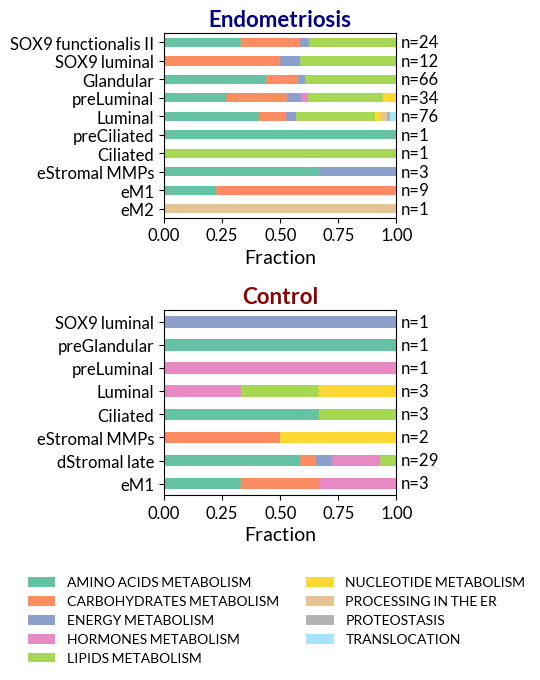

In [48]:
pathway = 'System'
condition1_color='#8B0000'
condition2_color='#000080'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 6), height_ratios=[1, 1])

legend_elements, colors = plot_single('up', ax1, pathway, sig)
plot_single('down', ax2, pathway, sig)

ax1.set_title('Endometriosis', fontsize=16, pad=5, color=condition2_color, fontweight="bold")
ax2.set_title('Control', fontsize=16, pad=5, color=condition1_color, fontweight="bold")

plt.figlegend(labels=legend_elements, 
              bbox_to_anchor=(0.5, -0.005),
              ncols=2 if pathway == 'System' else 2,
              frameon=False,
              loc='upper center')

plt.subplots_adjust(hspace=0.5)
#plt.tight_layout()
plt.savefig(f'{sc.settings.figdir}/Endometriosis-DE-{pathway}-Combined.pdf', 
            dpi=300, 
            bbox_inches='tight')

### Visualize distributions of significant tasks for specific cell types

In [49]:
from collections import defaultdict

unique_fea = set()
feature_dict = defaultdict(set)


sort_fn = lambda s: int(re.findall("\d+", s.split(' | ')[0])[0]) if 'i' not in s.split(' | ')[0] else int(re.findall("\d+", s.split(' | ')[0])[0])+1000

cell_show = sorted(sig.reset_index()['cell_type'].unique().tolist(), key=sort_fn)
cell_show = [c for c in cell_show if all(exc not in c.lower() for exc in ['usmcs'])] # 'stromal', 'fibroblast', 
cell_show2 = [cond + ct for ct in cell_show for cond in ['Control - ', 'Endometriosis - ']]
imm_cells = ['i13 | eM1']

for cell, df in sig.reset_index().groupby('cell_type'):
    features = df.sort_values('log2FC').feature
    sig_features = [f for f in features if f in filtered_sig_tasks]
    if cell in cell_show:
        for f in sig_features:
            unique_fea.add(f)
            if cell in imm_cells:
                feature_dict['Immune'].add(f)
            else:
                feature_dict['Epithelial'].add(f)
                
both_features = set()
for f in feature_dict['Epithelial']:
    if f in feature_dict['Immune']:
        both_features.add(f)
        
for f in both_features:
    feature_dict['Epithelial'].remove(f)
    feature_dict['Immune'].remove(f)
    
feature_dict['Both'] = both_features
feature_dict = {'Epithelial' : sorted(feature_dict['Epithelial']),
                'Both' : sorted(feature_dict['Both']),
                'Immune' : sorted(feature_dict['Immune'])
               }

feature_dict = {k : v for k, v in feature_dict.items() if len(v) > 0}

In [50]:
# g = sc.pl.stacked_violin(mt_total[mt_total.obs['E_celltype'].isin(cell_show2)], 
#                          feature_dict, 
#                          groupby='E_celltype', 
#                          categories_order=cell_show2,
#                          standard_scale='var',
#                          dendrogram=False,
#                          swap_axes=True,
#                          cmap='YlGnBu',
#                          cut=0,
#                          return_fig=True
#                          #save='Endometriosis-Comparison2'
#                         )
# g = g.get_axes()['mainplot_ax']

# xlabels = [t.get_text() for t in g.get_xticklabels()]
# xlabels = [t.split(' - ')[0] + ' - ' + t.split(' - ')[1].split(' | ')[1] for t in xlabels]
# _ = g.set_xticklabels(xlabels)

# plt.savefig(f'{sc.settings.figdir}/stacked_violin_Endometriosis-Comparison.pdf', dpi=300, bbox_inches='tight')

In [51]:
len(unique_fea)

106

In [52]:
#sig.loc[sig.index.isin(list(unique_fea), level=1)]

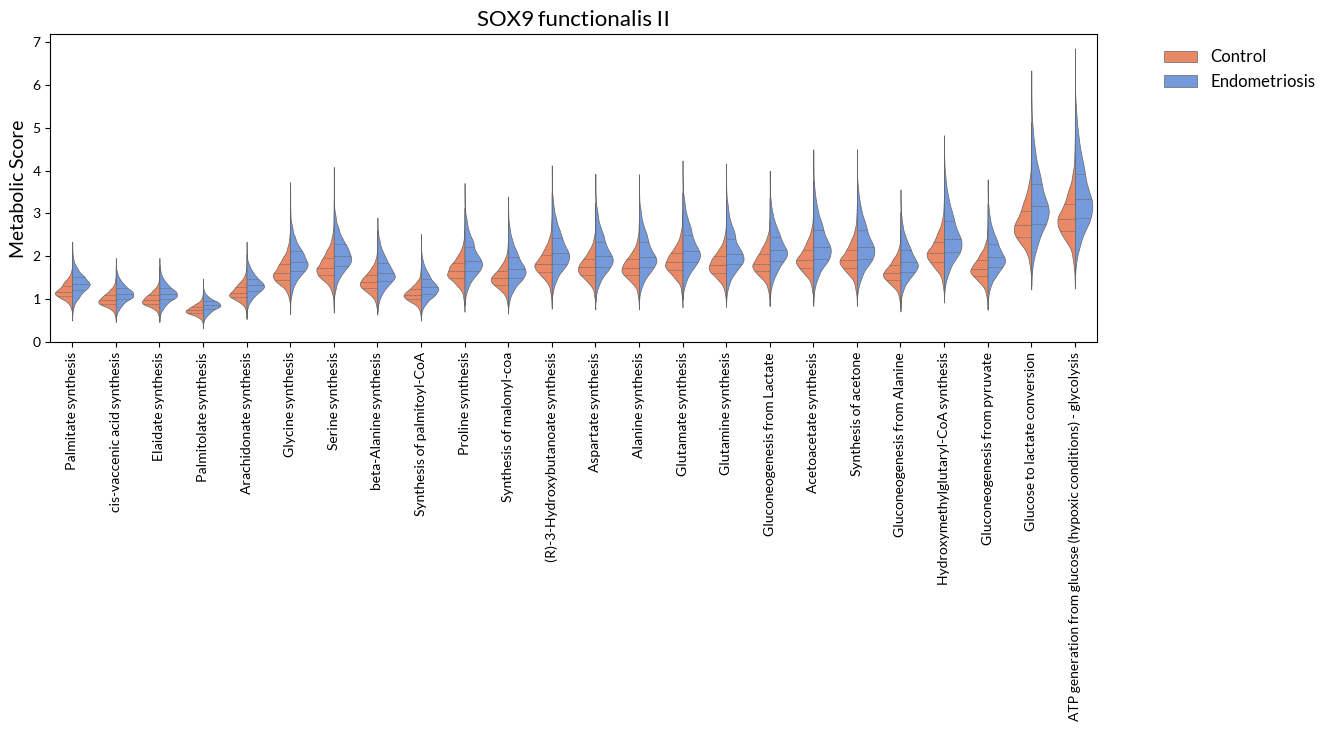

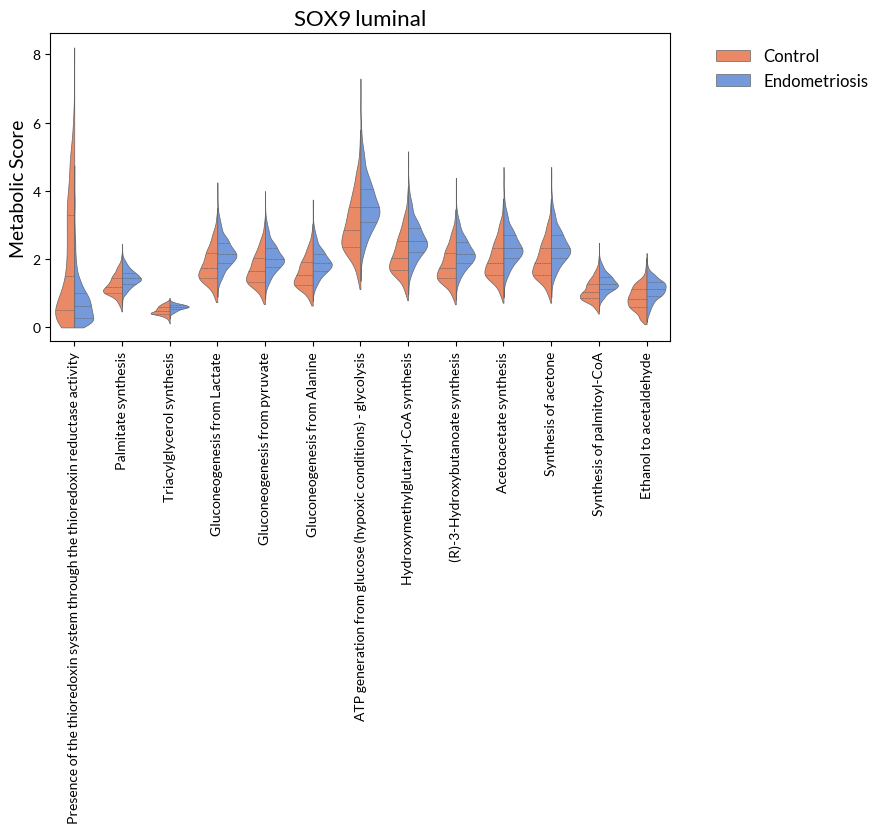

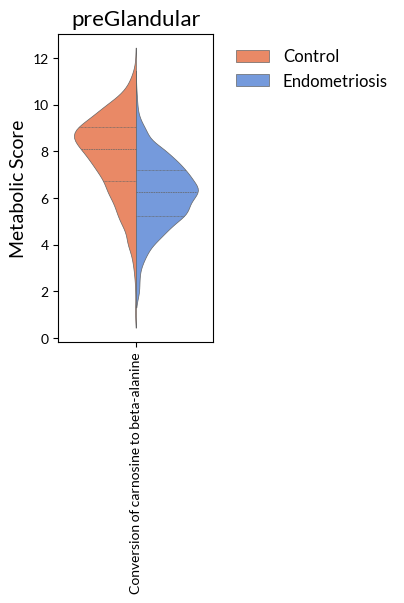

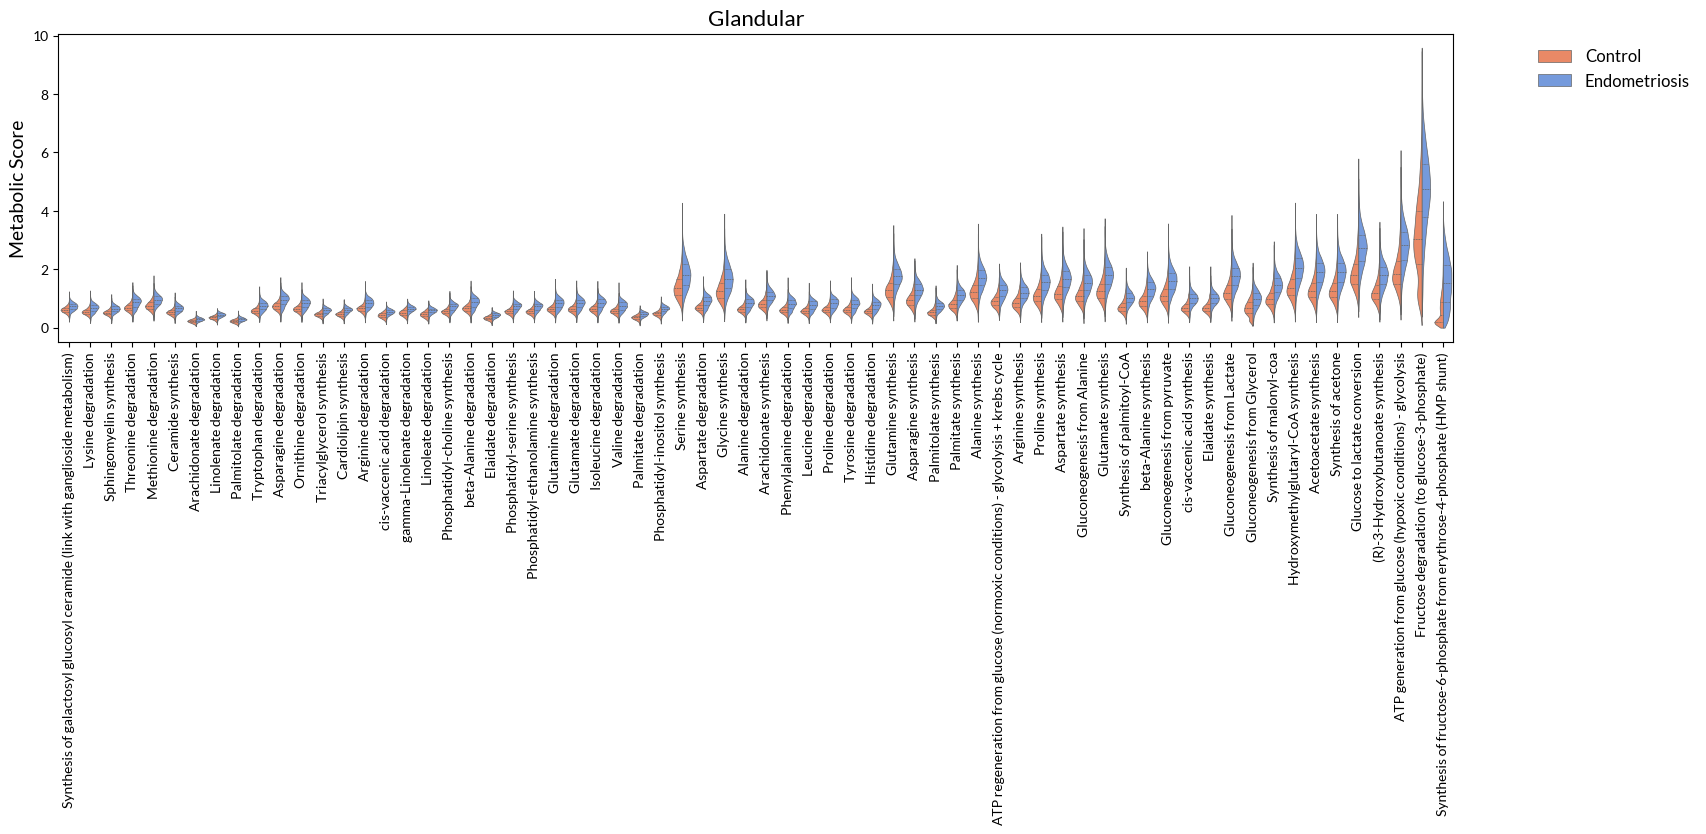

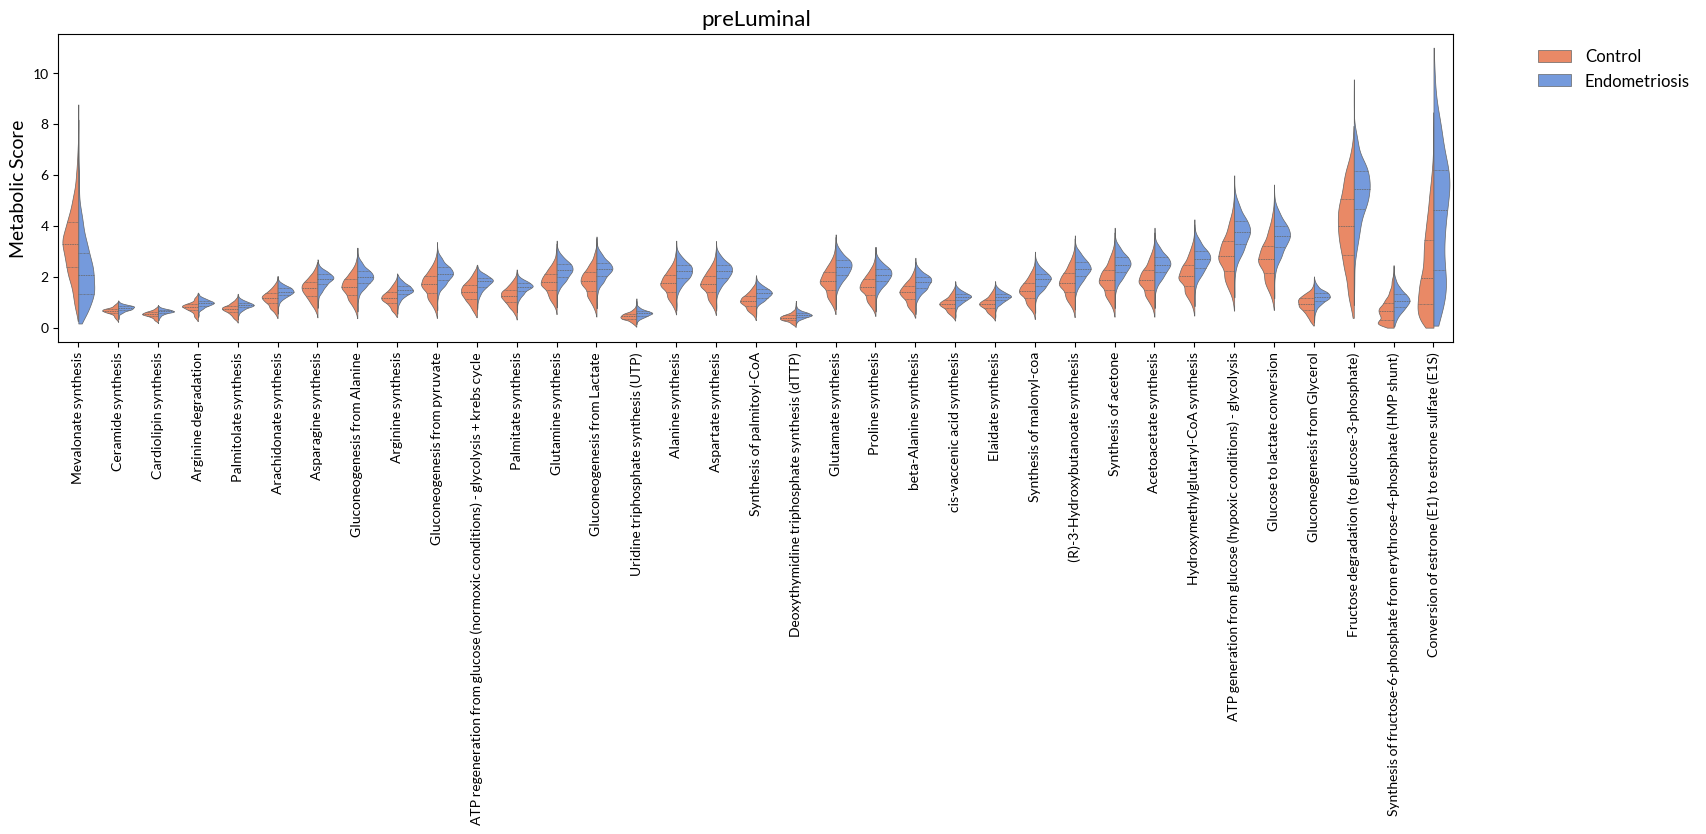

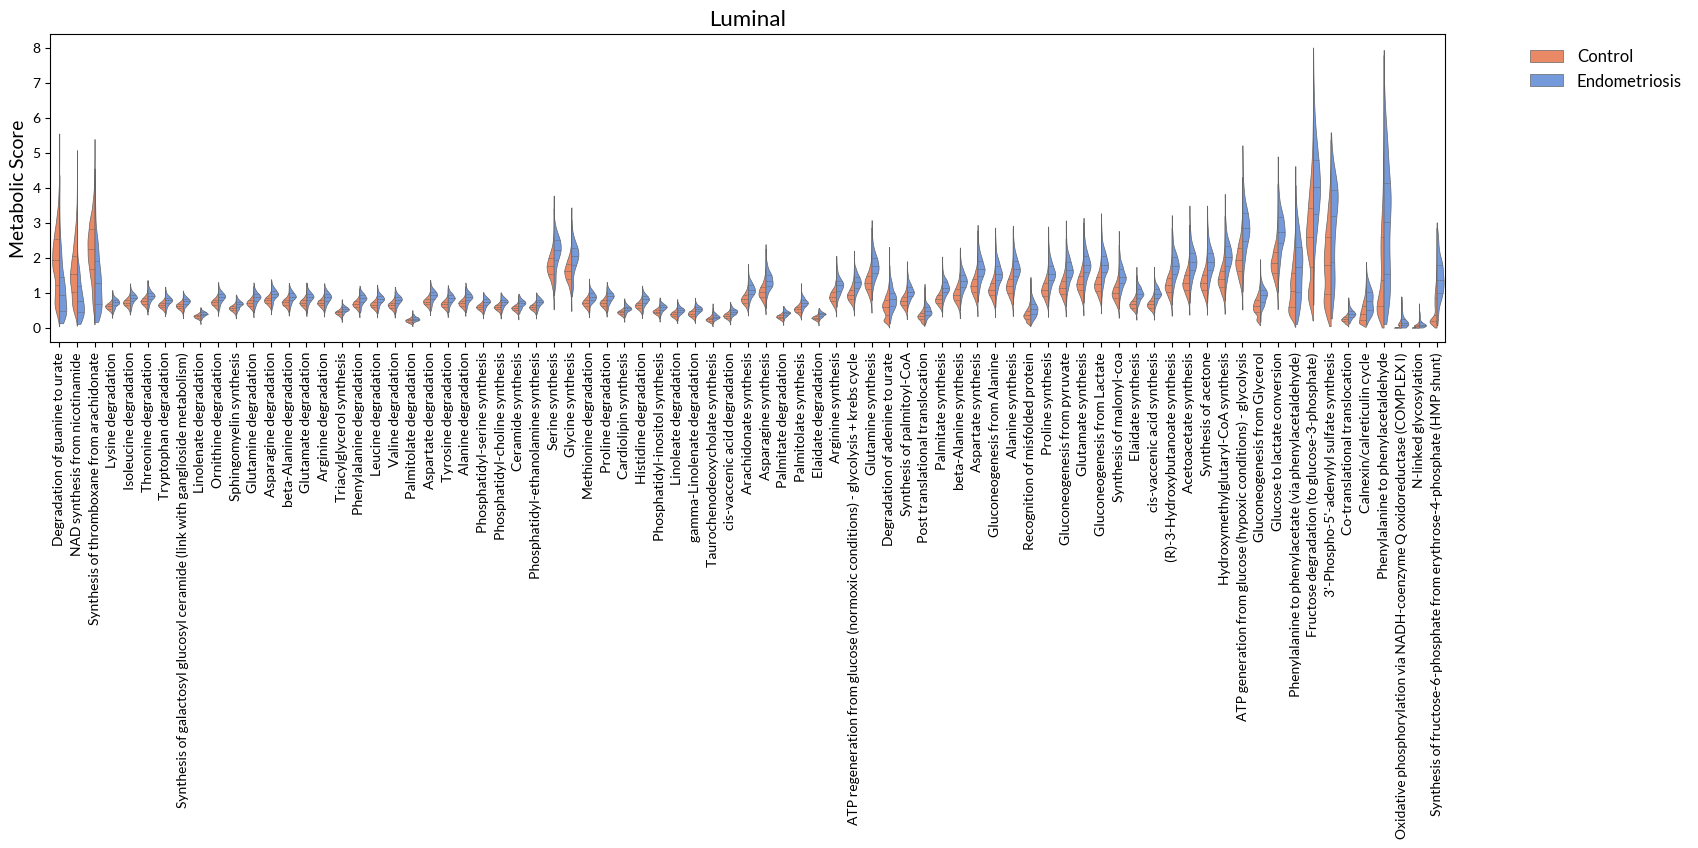

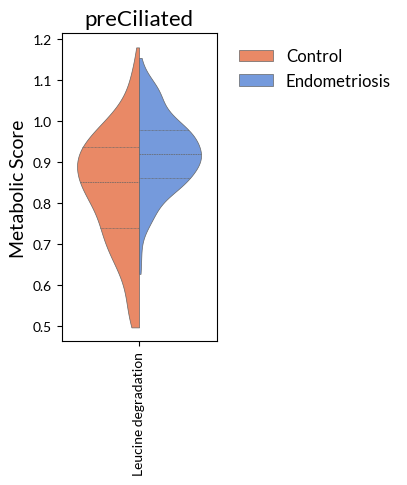

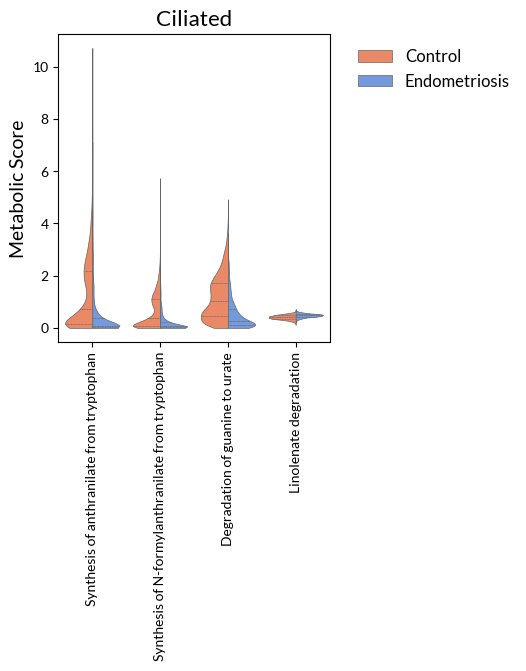

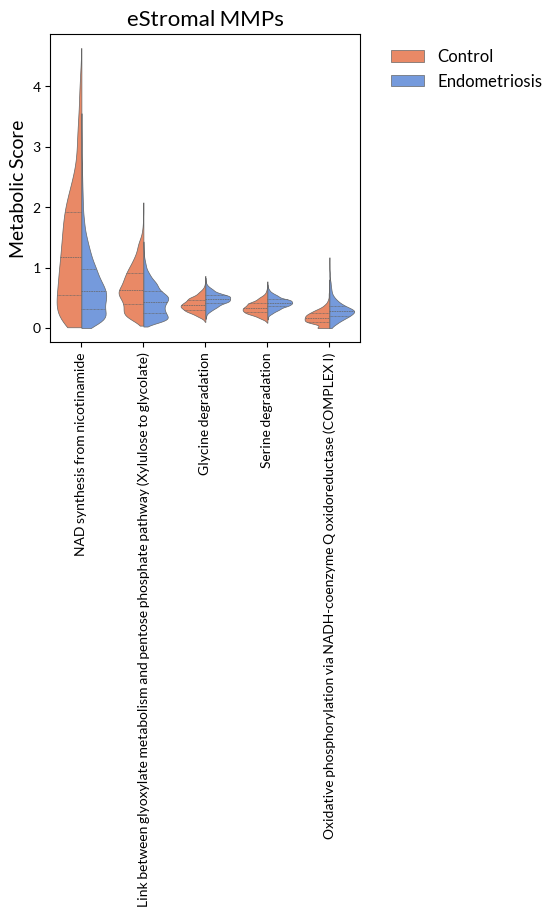

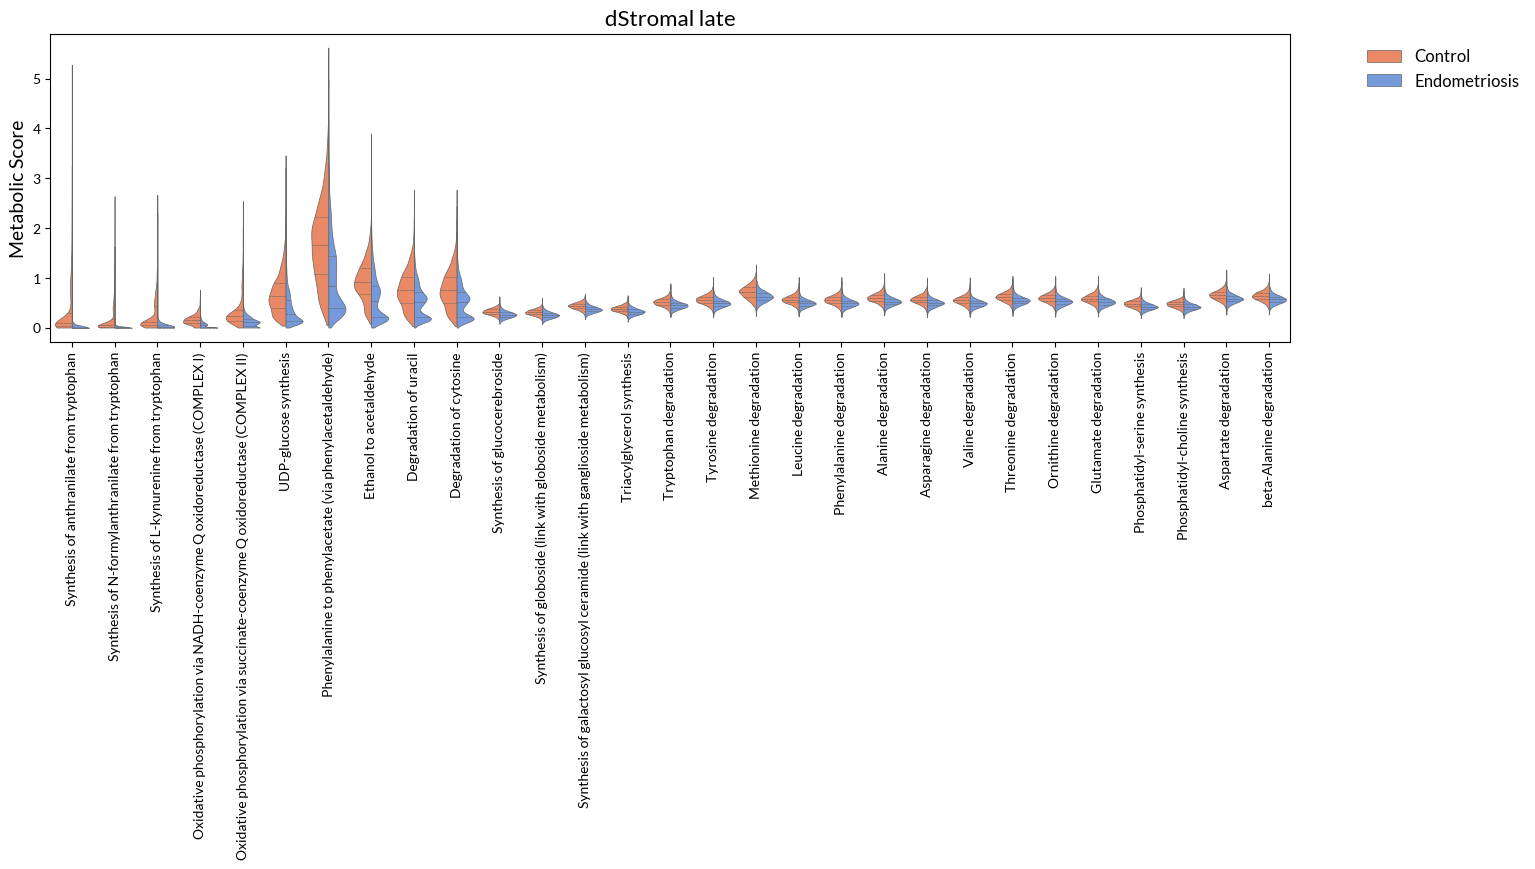

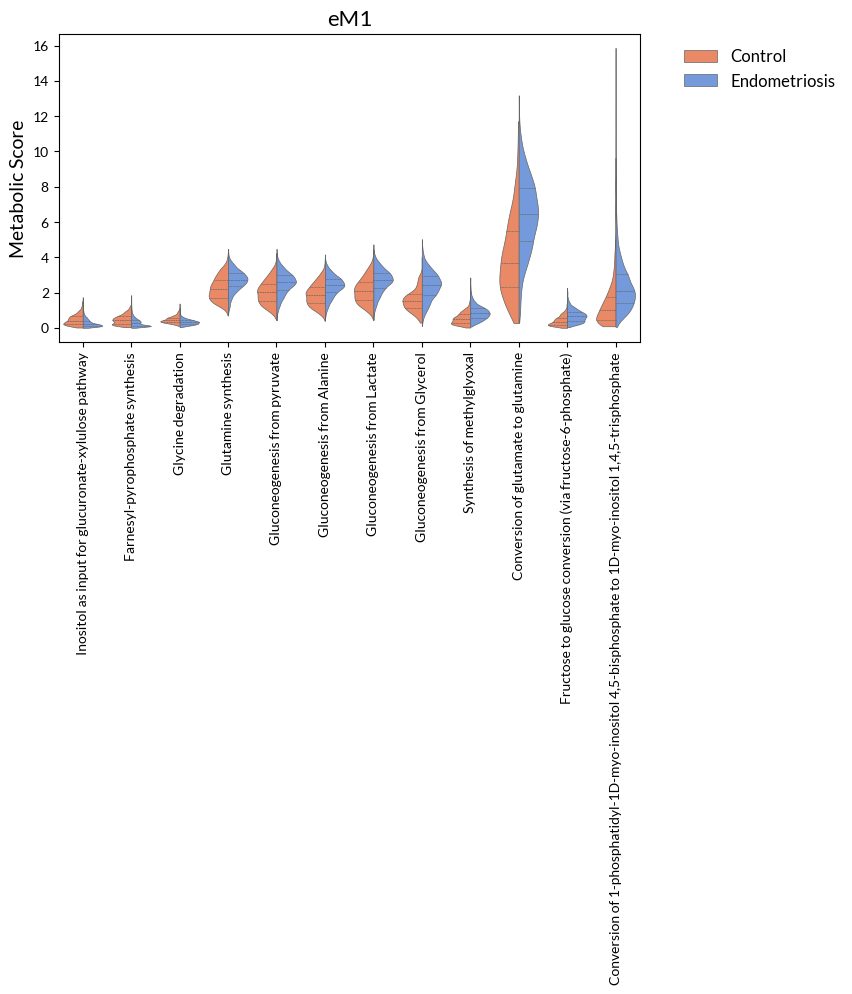

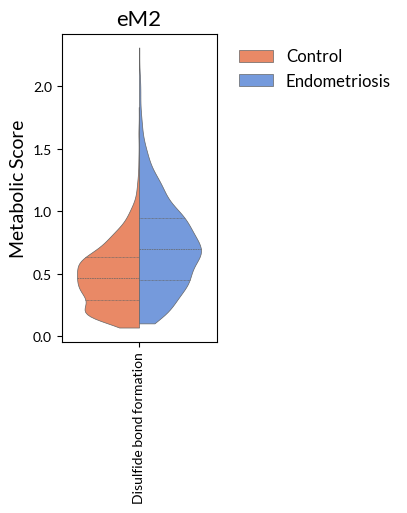

In [53]:
for c in cell_show:
    cname = c.split(' | ')[1]
    sig_features = [idx for idx in sig.loc[c].sort_values('log2FC').index if idx in filtered_sig_tasks]
    N = len(sig_features)
    if N > 0:
        width = min([18, 1.5 + 0.5*N])
        fig, ax = sccellfie.plotting.create_comparative_violin(adata=mt_total, 
                                                               significant_features=sig_features,
                                                               group1='Control', 
                                                               group2='Endometriosis',
                                                               condition_key='Endometriosis', 
                                                               cell_type_key='label_long',
                                                               celltype=c,
                                                               xlabel='',
                                                               ylabel='Metabolic Score',
                                                               palette=['coral','cornflowerblue'],
                                                               wrapped_title_length=100,
                                                               figsize=(width, 4),
                                                               fontsize=14,
                                                               title=f'{cname}',
                                                               tight_layout=False,
                                                               save=f'DE-Dist-{cname}'
                                                              )


## Evaluate changes

In [54]:
imm_rxn = sc.read_h5ad('/nfs/team292/eg22/Metabolic-Tasks/Endometrium/HECA/Imm-MT-2025-02-18/Immune-HECA_reactions.h5ad')

In [55]:
imm_bar_c = imm_rxn[(imm_rxn.obs['Endometrial_pathology'] == 'C') & (imm_rxn.obs['celltype'] == 'eM1')].obs.index.tolist()
imm_bar_e = imm_rxn[(imm_rxn.obs['Endometrial_pathology'] != 'C') & (imm_rxn.obs['celltype'] == 'eM1')].obs.index.tolist()

In [56]:
imm_rxn.uns['Rxn-Max-Genes'].loc[imm_bar_c, ['PI45PLC']].value_counts()

PI45PLC
PLCB2      273
PLCG2      246
PLCB3       33
PLCD1       20
PLCB1       11
PLCL1       11
PLCG1        7
PLCB4        4
PLCD3        4
PLCE1        2
PLCH1        2
PLCXD2       2
Name: count, dtype: int64

In [57]:
imm_rxn.uns['Rxn-Max-Genes'].loc[imm_bar_e, ['PI45PLC']].value_counts()

PI45PLC
PLCG2      2546
PLCB2       467
PLCB3        96
PLCB1        35
PLCD1        24
PLCG1        24
PLCD3        21
PLCL1        20
PLCB4         3
PLCH2         2
PLCXD2        1
Name: count, dtype: int64

### Heatmaps

In [58]:
idx = list(set([s[0] for s in sig.index]))

In [59]:
sig_cells = sorted(sig.reset_index()['cell_type'].unique().tolist(), key=sort_fn)
sorted_sig_cells = [cond + ct for ct in sig_cells for cond in ['Control - ', 'Endometriosis - ']]

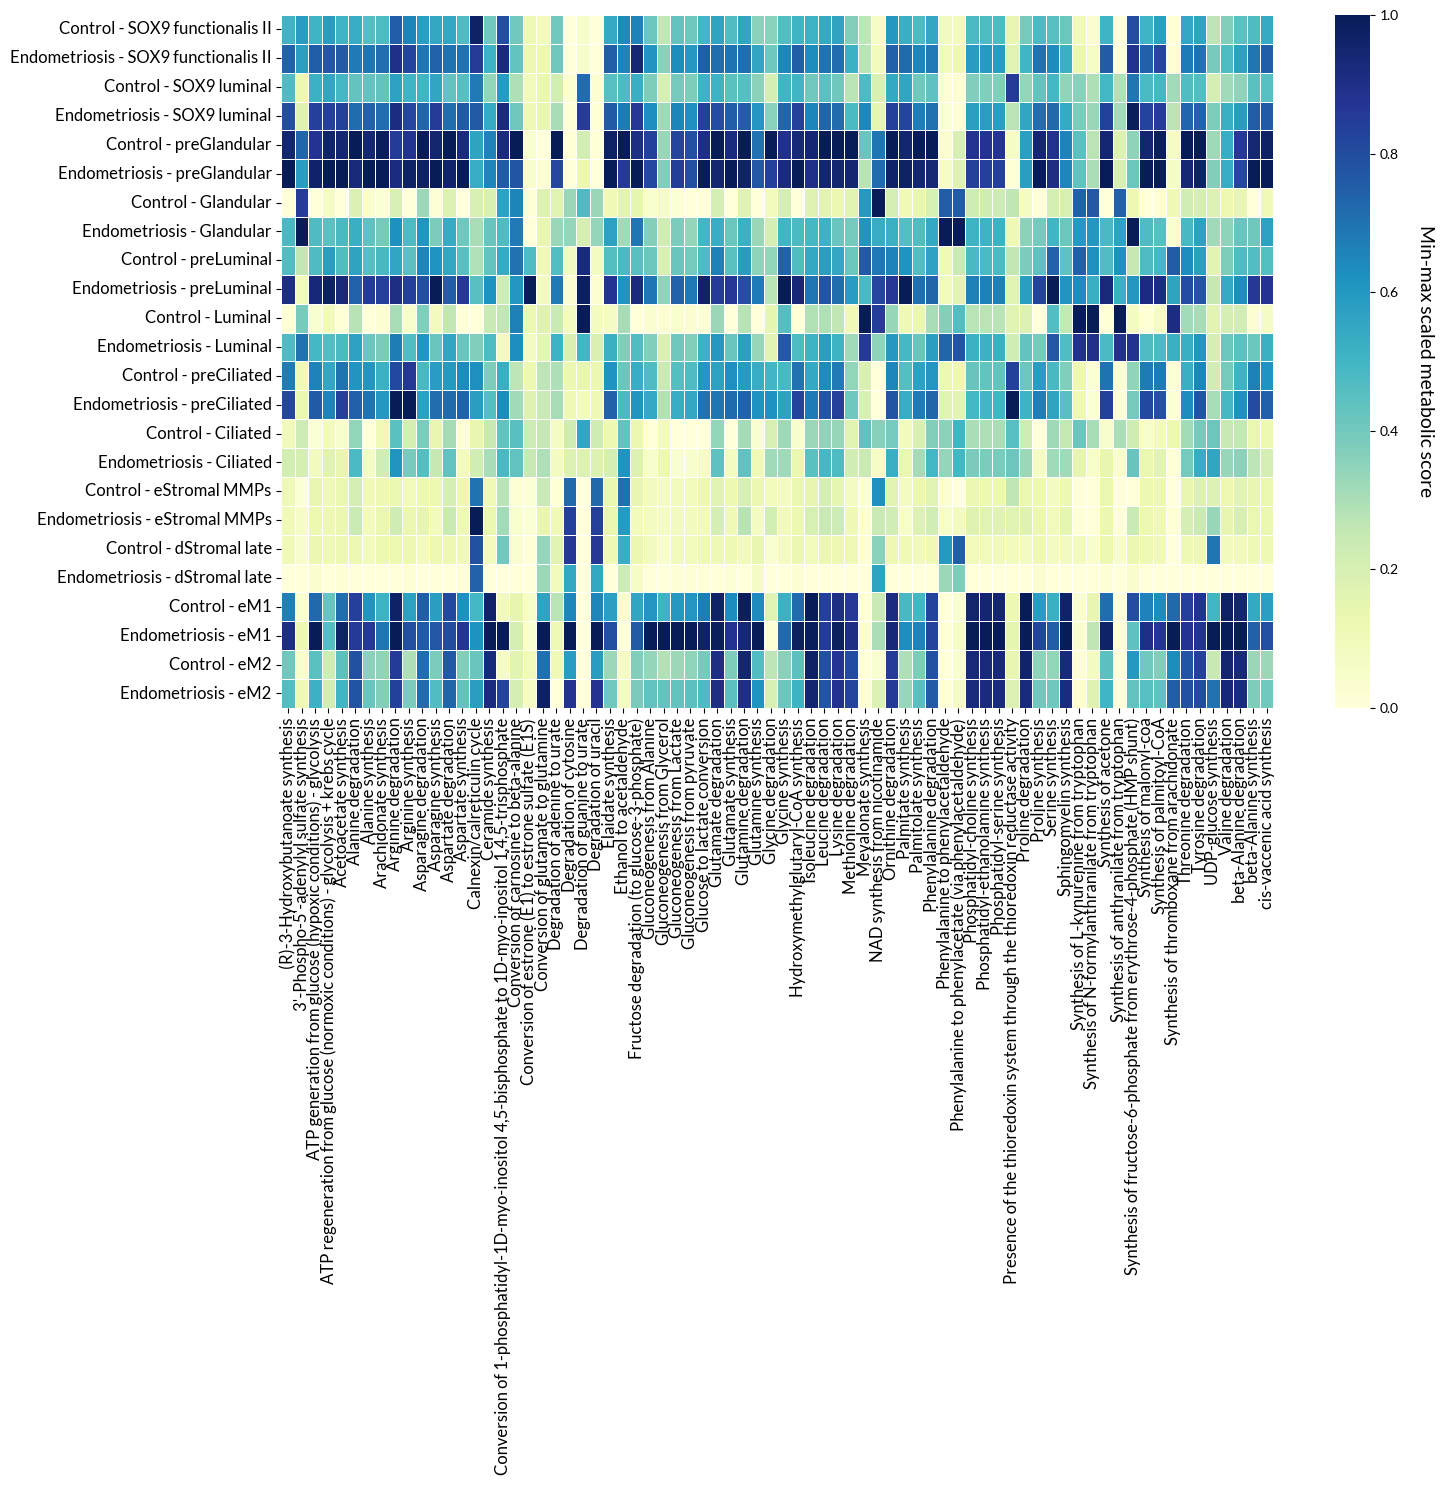

In [60]:
agg = agg.loc[sorted_sig_cells, (agg > 1.).any(axis=0)]

plt.figure(figsize=(16, 9))
input_df = sccellfie.preprocessing.matrix_utils.min_max_normalization(agg.T, axis=1)

g = sns.heatmap(input_df.T, cmap='YlGnBu', linewidths=0.5, xticklabels=1, yticklabels=1)
g.tick_params(axis='both', which='major', labelsize=12)

ylabels = [t.get_text() for t in g.get_yticklabels()]
ylabels = [t.split(' - ')[0] + ' - ' + t.split(' - ')[1].split(' | ')[1] for t in ylabels]
g.set_yticklabels(ylabels)


cbar = g.collections[0].colorbar
cbar.set_label('Min-max scaled metabolic score', size=14, rotation=270, labelpad=25)  # Change colorbar label size and rotation
#cbar.ax.tick_params(labelsize=12)  # Change tick label size

plt.savefig(f'{sc.settings.figdir}/Endometriosis-Filtered-Sig-Tasks.pdf', dpi=300, bbox_inches='tight')

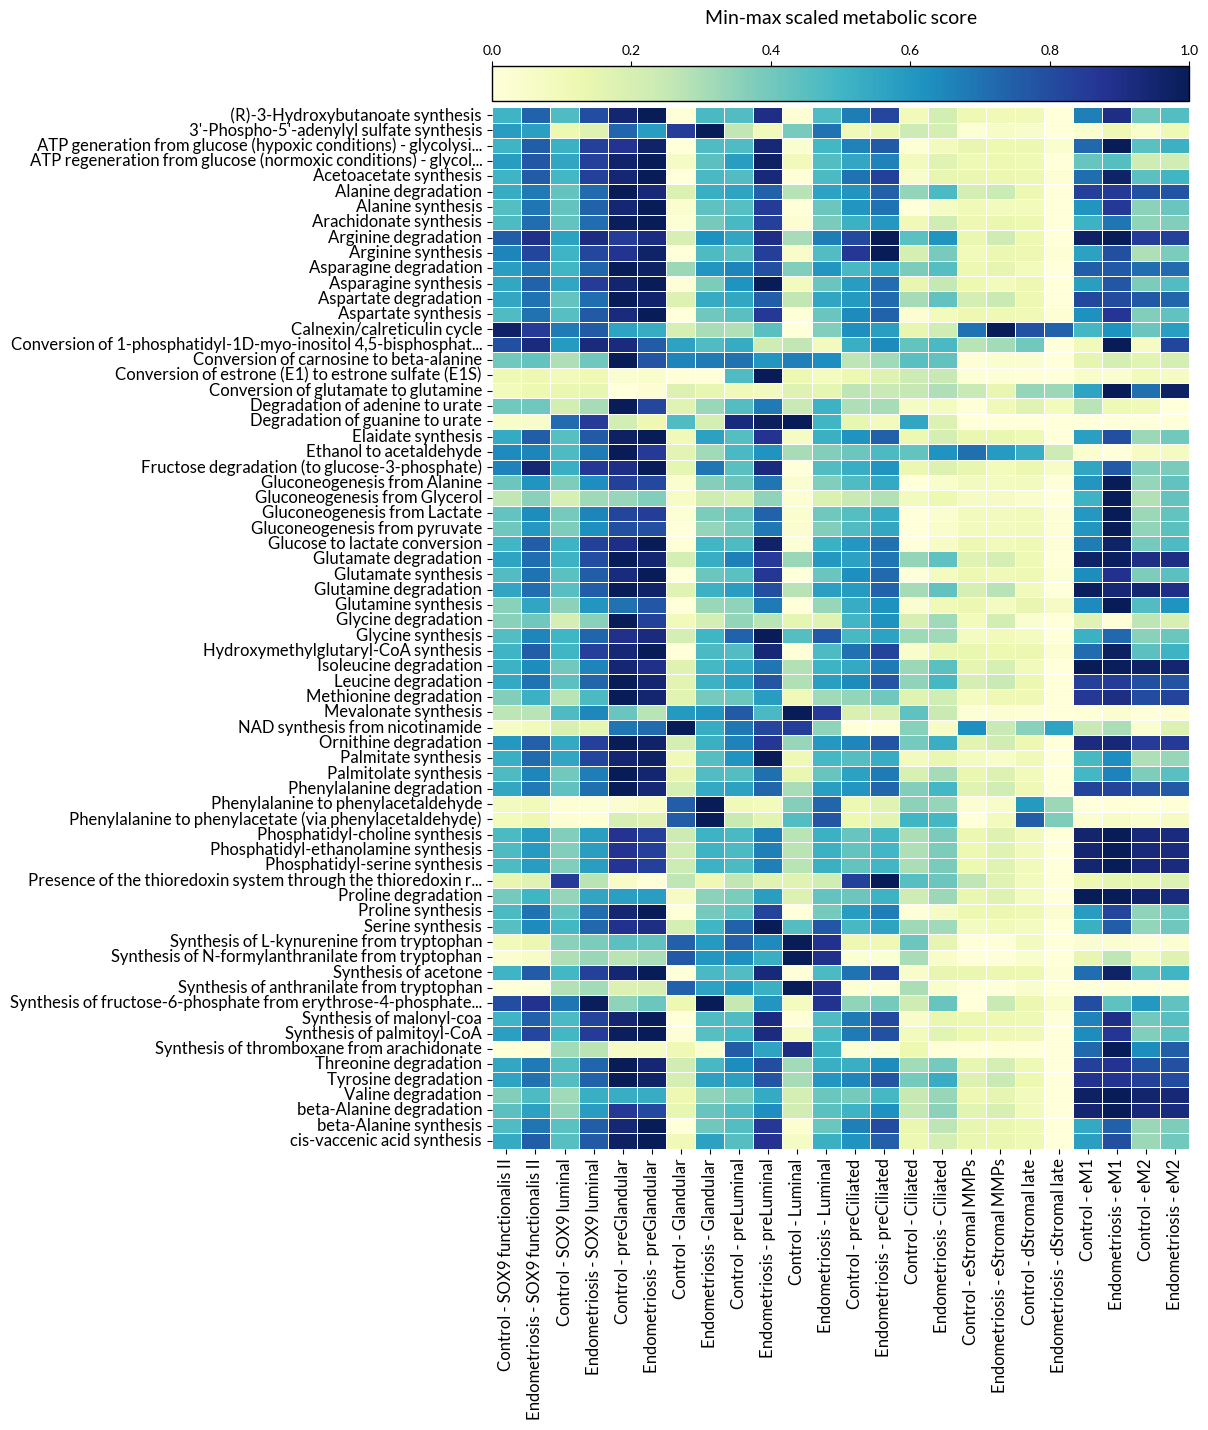

In [61]:
agg = agg.loc[sorted_sig_cells, (agg > 1.).any(axis=0)]

plt.figure(figsize=(9, 16))
input_df = sccellfie.preprocessing.matrix_utils.min_max_normalization(agg.T, axis=1)

g = sns.heatmap(input_df, cmap='YlGnBu', linewidths=0.5, xticklabels=1, yticklabels=1, 
                cbar_kws={'orientation': 'horizontal', 'location': 'top', 'pad' : 0.005})
g.tick_params(axis='both', which='major', labelsize=12)
ylabels = [t.get_text() for t in g.get_yticklabels()]
max_len = 60
g.set_yticklabels([t[:max_len] + '...' if len(t) > max_len else t for t in ylabels])

xlabels = [t.get_text() for t in g.get_xticklabels()]
xlabels = [t.split(' - ')[0] + ' - ' + t.split(' - ')[1].split(' | ')[1] for t in xlabels]
g.set_xticklabels(xlabels)

cbar = g.collections[0].colorbar
cbar.set_label('Min-max scaled metabolic score', size=14, labelpad=15)
cbar.outline.set_visible(True)
cbar.outline.set_linewidth(1)  # Adjust thickness
cbar.outline.set_edgecolor('black')  # Change frame color
plt.savefig(f'{sc.settings.figdir}/Endometriosis-Filtered-Sig-Tasks-Transposed.pdf', dpi=300, bbox_inches='tight')

### Comparative violin plots

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import textwrap
from math import ceil, gcd
from functools import reduce

def lcm(a, b):
    """Calculate least common multiple of two numbers"""
    return abs(a * b) // gcd(a, b)

def lcm_list(numbers):
    """Calculate least common multiple for a list of numbers"""
    return reduce(lcm, numbers)

def get_optimal_columns(data_list):
    """
    Determine optimal number of columns based on plot sizes and combinations.
    Returns both total columns and base unit for different plot sizes.
    """
    # Get number of features for each plot
    n_features = [len(df['Feature'].unique()) for df, _ in data_list]
    
    # Identify required spans based on plot categories
    spans = set()
    for n in n_features:
        if n >= 20:  # Very large plots
            spans.add(12)
        elif n >= 10:  # Large plots
            spans.add(8)
        elif n >= 5:  # Medium plots
            spans.add(6)
        else:  # Small plots
            spans.add(4)
    
    # Also add spans for common combinations
    spans.add(4)  # Base unit for small plots
    
    # Calculate LCM for all spans
    total_cols = lcm_list(list(spans))
    
    # Get the base unit (smallest span)
    base_unit = min(spans)
    
    return total_cols, base_unit

def group_plots(data_list, titles):
    """
    Group plots based on size and optimal combinations.
    Prioritizes grouping small plots together and sorts rows by total features.
    """
    total_cols, base_unit = get_optimal_columns(data_list)
    
    # Get number of features and create plot info
    plot_info = []
    for idx, ((df, _), title) in enumerate(zip(data_list, titles)):
        n_feat = len(df['Feature'].unique())
        key = chr(65 + idx)  # A, B, C, etc.
        
        if n_feat >= 20:
            category = 'very_large'
            span = total_cols
        elif n_feat >= 10:
            category = 'large'
            span = total_cols // 3 * 2
        elif n_feat >= 5:
            category = 'medium'
            span = total_cols // 2
        else:
            category = 'small'
            span = total_cols // 3
            
        plot_info.append((idx, key, n_feat, category, span, title))
    
    # Sort plots by category (size) and title
    size_order = {'very_large': 3, 'large': 2, 'medium': 1, 'small': 0}#{'very_large': 0, 'large': 1, 'medium': 2, 'small': 3}
    plot_info.sort(key=lambda x: (size_order[x[3]], x[5]))
    
    # Separate plots by category
    categorized_plots = {
        'small': [],
        'medium': [],
        'large': [],
        'very_large': []
    }
    
    for plot in plot_info:
        categorized_plots[plot[3]].append(plot)
    
    # Create rows with optimized grouping
    unsorted_rows = []
    remaining_plots = []
    
    # First, handle small plots in groups of 3
    small_plots = categorized_plots['small']
    while len(small_plots) >= 3:
        group = small_plots[:3]
        small_plots = small_plots[3:]
        unsorted_rows.append((group, total_cols))
    
    # If there are 1-2 small plots remaining, save them for mixing with other categories
    remaining_plots.extend(small_plots)
    
    # Add very large plots
    for plot in categorized_plots['very_large']:
        unsorted_rows.append(([plot], total_cols))
    
    # Mix remaining small plots with medium and large plots
    other_plots = (categorized_plots['large'] + 
                  categorized_plots['medium'] + 
                  remaining_plots)
    
    if other_plots:
        current_row = []
        current_span = 0
        
        # Sort to prioritize combining small plots with larger ones
        other_plots.sort(key=lambda x: (-size_order[x[3]], x[5]))
        
        for plot in other_plots:
            plot_span = plot[4]
            
            # If adding this plot would exceed row width, start new row
            if current_span + plot_span > total_cols:
                if current_row:
                    # Ensure equal spacing in the row
                    remaining_space = total_cols - current_span
                    if remaining_space > 0 and len(current_row) > 0:
                        extra_per_plot = remaining_space // len(current_row)
                        current_row = [(p[0], p[1], p[2], p[3], p[4] + extra_per_plot, p[5]) 
                                     for p in current_row]
                    unsorted_rows.append((current_row, total_cols))
                current_row = []
                current_span = 0
            
            current_row.append(plot)
            current_span += plot_span
            
            # If row is full, add it to rows
            if current_span == total_cols:
                unsorted_rows.append((current_row, total_cols))
                current_row = []
                current_span = 0
        
        # Handle any remaining plots
        if current_row:
            # If there's a single small plot, try to redistribute from previous row
            if (len(current_row) == 1 and 
                current_row[0][3] == 'small' and 
                len(unsorted_rows) > 0):
                last_row = unsorted_rows[-1][0]
                # If last row has space, move a plot there
                if sum(p[4] for p in last_row) + current_row[0][4] <= total_cols:
                    last_row.append(current_row[0])
                    unsorted_rows[-1] = (last_row, total_cols)
                    current_row = []
            
            if current_row:
                remaining_space = total_cols - current_span
                if remaining_space > 0 and len(current_row) > 0:
                    extra_per_plot = remaining_space // len(current_row)
                    current_row = [(p[0], p[1], p[2], p[3], p[4] + extra_per_plot, p[5]) 
                                 for p in current_row]
                unsorted_rows.append((current_row, total_cols))
    
    # Sort rows by total number of features (descending)
    sorted_rows = sorted(
        unsorted_rows,
        key=lambda row: sum(plot[2] for plot in row[0]),
        reverse=False #True
    )
    # Sort within row
    sorted_rows = [(sorted(row[0], key=lambda x: x[2], reverse=True), row[1]) for row in sorted_rows]
    
    return sorted_rows, total_cols

def adjust_font_size(text, n_features, base_size=10, width=35):
    """
    Dynamically adjust font size based on text length and number of features.
    More consistent sizing across different text lengths.
    """
    # First wrap the text
    wrapped = textwrap.fill(text, width=width)  # Reduced width for better wrapping
    n_lines = len(wrapped.split('\n'))
    max_line_length = max(len(line) for line in wrapped.split('\n'))
    
    # Start with base size adjustment based on number of features
    if n_features >= 20:
        base_size = 8
    elif n_features >= 10:
        base_size = 9
    else:
        base_size = 10
    
    # Adjust size based on text characteristics
    if n_lines > 1:
        size_reduction = (n_lines - 1) * 2  # Reduced penalty for multiple lines
    else:
        # For single lines, adjust based on length
        size_reduction = max(0, (max_line_length - 15) // 10)
    
    # Ensure consistent minimum size
    final_size = max(6, base_size - size_reduction)
    
    return final_size, wrapped

def create_subplot_panel(data_list, titles, width=16, height=4, hspace=2, wspace=10, ticklabel_width=45):
    """
    Create an optimized subplot panel using subplot_mosaic.
    """
    # Group plots and get total columns
    grouped_rows, total_cols = group_plots(data_list, titles)
    
    # Create layout matrix
    layout = []
    ax_row = dict()
    for row_plots, row_cols in grouped_rows:
        current_row = []
        remaining_cols = total_cols
        
        for plot in row_plots:
            idx, key, n_feat, category, span, title = plot  # Unpack all 6 values
            current_row.extend([key] * span)
            remaining_cols -= span
        
        # Fill any remaining columns
        if remaining_cols > 0 and current_row:
            current_row.extend([current_row[-1]] * remaining_cols)
            
        layout.append(current_row)
        row_ele = set(current_row)
        for ax_ in row_ele:
            ax_row[ax_] = len(row_ele)
    # Create figure with more aggressive spacing
    fig_width = width
    fig_height = height * len(layout)  # Further increased height per row
    fig, axd = plt.subplot_mosaic(
        layout, 
        figsize=(fig_width, fig_height),
        gridspec_kw={
            'width_ratios': [1]*total_cols,
            'hspace': hspace,  # More vertical space
            'wspace': wspace   # More horizontal space
        }
    )
    
    # Create plots
    plot_keys = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'[:len(data_list)])
    
    # Find the rightmost plot in the first row
    first_row = layout[0]
    rightmost_key = first_row[-1]
    
    for i, ((df, params), title) in enumerate(zip(data_list, titles)):
        ax = axd[plot_keys[i]]
        n_features = len(df['Feature'].unique())
        
        # Create violin plot
        sns.violinplot(
            data=df,
            x='Feature',
            y=params['ylabel'],
            hue='Group',
            cut=params['violin_cut'],
            split=True,
            inner="quart",
            linewidth=0.5,
            density_norm="width",
            palette=params['palette'],
            ax=ax
        )
        
        # Style the plot
        ax.set_xlabel(params['xlabel'], fontsize=params['fontsize'])
        ax.set_ylabel(params['ylabel'], fontsize=params['fontsize'])
        
        # Handle x-tick labels with dynamic font sizing
        x_labels = []
        x_fontsize = []
        
        for label in ax.get_xticklabels():
            fontsize, wrapped_text = adjust_font_size(
                label.get_text(),
                n_features,
                base_size=params['fontsize'] - 2,
                width=ticklabel_width
            )
            x_labels.append(wrapped_text)
            x_fontsize.append(fontsize)
        
        ax.set_xticklabels(
            labels=x_labels,
            rotation=90,
            rotation_mode='anchor',
            ha='right',
            va='center'
        )
        
        # Set individual font sizes for each label
        for label, fontsize in zip(ax.get_xticklabels(), x_fontsize):
            label.set_fontsize(fontsize)
        
        ax.tick_params(axis='y', labelsize=params['fontsize'] - 2)
        
        # Add legend only to the rightmost plot of the first row
        if plot_keys[i] == rightmost_key:
            leg = ax.legend(
                frameon=False,
                fontsize=params['fontsize'] - 2,
                bbox_to_anchor=(1.01, 1),
                loc='upper left'
            )
        else:
            ax.legend().remove()
        
        # Set title
        ax.set_title(title, fontsize=params['fontsize'] + 2, pad=-0.5)
    
    # First adjust the overall layout
    plt.tight_layout(rect=[0, 0, 0.92, 0.98])  # More conservative margins
    
    # Then fine-tune each subplot position
    frac = 0.03 # Fraction to reduce width
    for k, ax in axd.items():
        if ax_row[k] > 1:
            pos = ax.get_position()
            # Calculate new position with more space for labels
            new_pos = [
                pos.x0 + (pos.width * frac*ax_row[k])/2.,                    # Keep x position
                pos.y0,
                pos.width * (1. - frac*ax_row[k]),         # Reduce width more
                pos.height*0.98, # Reduce height more
            ]
            ax.set_position(new_pos)
        
    
    return fig

In [63]:
# All cells
data_list = []
titles_list = []

for c in cell_show:
    cname = c.split(' | ')[1]
    sig_features = [idx for idx in sig.loc[c].sort_values('log2FC').index if idx in filtered_sig_tasks]
    N = len(sig_features)
    if N > 0:
        # Filter cells for each group
        cells_group1 = mt_total.obs.loc[(mt_total.obs['Endometriosis'] == 'Control') & 
                                      (mt_total.obs['label_long'] == c)].index
        cells_group2 = mt_total.obs.loc[(mt_total.obs['Endometriosis'] == 'Endometriosis') & 
                                      (mt_total.obs['label_long'] == c)].index
        
        # Compile data for significant features
        feature_dfs = []
        for feature in sig_features:
            series1 = mt_total[cells_group1].to_df()[feature]
            series2 = mt_total[cells_group2].to_df()[feature]
            df = pd.concat([series1, series2], axis=0)
            df = df.reset_index(level=0)
            df = df.rename(columns={feature: 'Metabolic Score'})
            df['Feature'] = feature
            df['Group'] = pd.Series(['Control'] * len(series1) + ['Endometriosis'] * len(series2))
            feature_dfs.append(df)
        
        feature_df = pd.concat(feature_dfs, axis=0)
        
        # Store plot parameters
        params = {
            'significant_features': sig_features,
            'xlabel': '',
            'ylabel': 'Metabolic Score',
            'violin_cut': 0,
            'palette': ['coral', 'cornflowerblue'],
            'fontsize': 14,
            'lgd_bbox_to_anchor': (1.01, 1),
            'lgd_loc': 'upper right'
        }
        
        data_list.append((feature_df, params))
        titles_list.append(cname)

# Create the combined figure
fig = create_subplot_panel(data_list, titles_list, width=14, height=4, ticklabel_width=40)

# Save the figure
fig.savefig(f'{sc.settings.figdir}/violin_comparative-DE-All.pdf', bbox_inches='tight', dpi=300)
plt.close('all')

In [64]:
# Selected cells
data_list = []
titles_list = []

cell_select = ['3 | SOX9 functionalis II',
              '4 | SOX9 luminal',
              '6 | preGlandular',
              '7 | Glandular',
              '10 | preLuminal',
              '11 | Luminal',
              'i13 | eM1',
              'i14 | eM2',
              ]

for c in cell_select:
    cname = c.split(' | ')[1]
    sig_features = [idx for idx in sig.loc[c].sort_values('log2FC').index if idx in filtered_sig_tasks]
    N = len(sig_features)
    if N > 0:
        # Filter cells for each group
        cells_group1 = mt_total.obs.loc[(mt_total.obs['Endometriosis'] == 'Control') & 
                                      (mt_total.obs['label_long'] == c)].index
        cells_group2 = mt_total.obs.loc[(mt_total.obs['Endometriosis'] == 'Endometriosis') & 
                                      (mt_total.obs['label_long'] == c)].index
        
        # Compile data for significant features
        feature_dfs = []
        for feature in sig_features:
            series1 = mt_total[cells_group1].to_df()[feature]
            series2 = mt_total[cells_group2].to_df()[feature]
            df = pd.concat([series1, series2], axis=0)
            df = df.reset_index(level=0)
            df = df.rename(columns={feature: 'Metabolic Score'})
            df['Feature'] = feature
            df['Group'] = pd.Series(['Control'] * len(series1) + ['Endometriosis'] * len(series2))
            feature_dfs.append(df)
        
        feature_df = pd.concat(feature_dfs, axis=0)
        
        # Store plot parameters
        params = {
            'significant_features': sig_features,
            'xlabel': '',
            'ylabel': 'Metabolic Score',
            'violin_cut': 0,
            'palette': ['coral', 'cornflowerblue'],
            'fontsize': 14,
            'lgd_bbox_to_anchor': (1.01, 1),
            'lgd_loc': 'upper right'
        }
        
        data_list.append((feature_df, params))
        titles_list.append(cname)

# Create the combined figure
fig = create_subplot_panel(data_list, titles_list, width=14, height=4, ticklabel_width=40)

# Save the figure
fig.savefig(f'{sc.settings.figdir}/violin_comparative-DE-Select.pdf', bbox_inches='tight', dpi=300)
plt.close('all')

In [65]:
# Selected cells
data_list = []
titles_list = []

cell_select = [
              'i13 | eM1',
              'i14 | eM2',
              ]

for c in cell_select:
    cname = c.split(' | ')[1]
    sig_features = [idx for idx in sig.loc[c].sort_values('log2FC').index if idx in filtered_sig_tasks]
    N = len(sig_features)
    if N > 0:
        # Filter cells for each group
        cells_group1 = mt_total.obs.loc[(mt_total.obs['Endometriosis'] == 'Control') & 
                                      (mt_total.obs['label_long'] == c)].index
        cells_group2 = mt_total.obs.loc[(mt_total.obs['Endometriosis'] == 'Endometriosis') & 
                                      (mt_total.obs['label_long'] == c)].index
        
        # Compile data for significant features
        feature_dfs = []
        for feature in sig_features:
            series1 = mt_total[cells_group1].to_df()[feature]
            series2 = mt_total[cells_group2].to_df()[feature]
            df = pd.concat([series1, series2], axis=0)
            df = df.reset_index(level=0)
            df = df.rename(columns={feature: 'Metabolic Score'})
            df['Feature'] = feature
            df['Group'] = pd.Series(['Control'] * len(series1) + ['Endometriosis'] * len(series2))
            feature_dfs.append(df)
        
        feature_df = pd.concat(feature_dfs, axis=0)
        
        # Store plot parameters
        params = {
            'significant_features': sig_features,
            'xlabel': '',
            'ylabel': 'Metabolic Score',
            'violin_cut': 0,
            'palette': ['coral', 'cornflowerblue'],
            'fontsize': 14,
            'lgd_bbox_to_anchor': (1.01, 1),
            'lgd_loc': 'upper right'
        }
        
        data_list.append((feature_df, params))
        titles_list.append(cname)

# Create the combined figure
fig = create_subplot_panel(data_list, titles_list, width=10, height=3, ticklabel_width=40)

# Save the figure
fig.savefig(f'{sc.settings.figdir}/violin_comparative-DE-Macrophages.pdf', bbox_inches='tight', dpi=300)
plt.close('all')

In [67]:
filtered_epithelial = agg.loc[[prefix + ct for prefix in ['Control - ', 'Endometriosis - '] for ct in ['7 | Glandular', '11 | Luminal']], #'3 | SOX9 functionalis II', '6 | preGlandular', 
                              (agg > 1.5).any(axis=0)].columns.tolist()

In [82]:
# Selected cells
data_list = []
titles_list = []

cell_select = ['i13 | eM1',
               'i14 | eM2',
               '7 | Glandular',
               '11 | Luminal',
              ]

for c in cell_select:
    cname = c.split(' | ')[1]
    if c in ['i13 | eM1', 'i14 | eM2']:
        sig_features = [idx for idx in sig.loc[c].sort_values('log2FC').index if idx in filtered_sig_tasks]
    else:
        sig_features = [idx for idx in sig.loc[c].sort_values('log2FC').index if idx in filtered_epithelial]
    N = len(sig_features)
    if N > 0:
        # Filter cells for each group
        cells_group1 = mt_total.obs.loc[(mt_total.obs['Endometriosis'] == 'Control') & 
                                      (mt_total.obs['label_long'] == c)].index
        cells_group2 = mt_total.obs.loc[(mt_total.obs['Endometriosis'] == 'Endometriosis') & 
                                      (mt_total.obs['label_long'] == c)].index
        
        # Compile data for significant features
        feature_dfs = []
        for feature in sig_features:
            series1 = mt_total[cells_group1].to_df()[feature]
            series2 = mt_total[cells_group2].to_df()[feature]
            df = pd.concat([series1, series2], axis=0)
            df = df.reset_index(level=0)
            df = df.rename(columns={feature: 'Metabolic Score'})
            df['Feature'] = feature
            df['Group'] = pd.Series(['Control'] * len(series1) + ['Endometriosis'] * len(series2))
            feature_dfs.append(df)
        
        feature_df = pd.concat(feature_dfs, axis=0)
        
        # Store plot parameters
        params = {
            'significant_features': sig_features,
            'xlabel': '',
            'ylabel': 'Metabolic Score',
            'violin_cut': 0,
            'palette': ['coral', 'cornflowerblue'],
            'fontsize': 14,
            'lgd_bbox_to_anchor': (1.01, 1),
            'lgd_loc': 'upper right'
        }
        
        data_list.append((feature_df, params))
        titles_list.append(cname)

# Create the combined figure
fig = create_subplot_panel(data_list, titles_list, width=10, height=3., hspace=2.2, wspace=25, ticklabel_width=30) #  wspace=30, 

# Save the figure
fig.savefig(f'{sc.settings.figdir}/violin_comparative-DE-Epi&Mac.pdf', bbox_inches='tight', dpi=300)
plt.close('all')

In [69]:
# Selected cells
data_list = []
titles_list = []

cell_select = ['6 | preGlandular', '7 | Glandular', '10 | preLuminal', '11 | Luminal'
              ]

for c in cell_select:
    cname = c.split(' | ')[1]
    sig_features = [idx for idx in sig.loc[c].sort_values('log2FC').index if idx in filtered_epithelial]
    N = len(sig_features)
    if N > 0:
        # Filter cells for each group
        cells_group1 = mt_total.obs.loc[(mt_total.obs['Endometriosis'] == 'Control') & 
                                      (mt_total.obs['label_long'] == c)].index
        cells_group2 = mt_total.obs.loc[(mt_total.obs['Endometriosis'] == 'Endometriosis') & 
                                      (mt_total.obs['label_long'] == c)].index
        
        # Compile data for significant features
        feature_dfs = []
        for feature in sig_features:
            series1 = mt_total[cells_group1].to_df()[feature]
            series2 = mt_total[cells_group2].to_df()[feature]
            df = pd.concat([series1, series2], axis=0)
            df = df.reset_index(level=0)
            df = df.rename(columns={feature: 'Metabolic Score'})
            df['Feature'] = feature
            df['Group'] = pd.Series(['Control'] * len(series1) + ['Endometriosis'] * len(series2))
            feature_dfs.append(df)
        
        feature_df = pd.concat(feature_dfs, axis=0)
        
        # Store plot parameters
        params = {
            'significant_features': sig_features,
            'xlabel': '',
            'ylabel': 'Metabolic Score',
            'violin_cut': 0,
            'palette': ['coral', 'cornflowerblue'],
            'fontsize': 14,
            'lgd_bbox_to_anchor': (1.01, 1),
            'lgd_loc': 'upper right'
        }
        
        data_list.append((feature_df, params))
        titles_list.append(cname)

# Create the combined figure
fig = create_subplot_panel(data_list, titles_list, width=10, height=4, ticklabel_width=40)

# Save the figure
fig.savefig(f'{sc.settings.figdir}/violin_comparative-DE-Epi-Important.pdf', bbox_inches='tight', dpi=300)
plt.close('all')

In [ ]:
epithelial = ['3 | SOX9 functionalis II',
 '4 | SOX9 luminal',
 '6 | preGlandular',
 '7 | Glandular',
 '10 | preLuminal',
 '11 | Luminal',
 '12 | preCiliated',
 '13 | Ciliated',
]

In [ ]:
df = sig.loc[epithelial, :]
[f for f in df.loc[df['cohens_d'] >= cohen_threshold].reset_index().feature.unique().tolist() if f in filtered_sig_tasks]

In [ ]:
epi_tasks = []
for ct, df in sig.reset_index().groupby('cell_type'):
    if ct in ['3 | SOX9 functionalis II',
 #'4 | SOX9 luminal',
 '6 | preGlandular',
 '7 | Glandular',
# '10 | preLuminal',
# '12 | preCiliated',
# '13 | Ciliated',
]:
        epi_tasks.append(df['feature'].unique().tolist())
        
shared_tasks = set(epi_tasks[0]).intersection(*epi_tasks[1:])

In [ ]:
shared_tasks